Instead of using `python-constraint`, we want to use Googles OR-Tools CP-SAT solver to work this problem.

This is because it features [better performance and scalability](https://github.com/google/or-tools/blob/stable/ortools/sat/docs/troubleshooting.md#improving-performance-with-multiple-workers) for larger problems (mutli threaded optimizations).


In [114]:
from csv import DictReader


def load_data_from_csv(filepath):
    """Load data from CSV file"""
    courses = {}

    with open(filepath, 'r', encoding='utf-8') as file:
        reader = DictReader(file, delimiter=';')

        for row in reader:
            course = row['Studiengang']
            courses[course] = {
                'num_groups': int(row['Projektgruppen']),
                'num_committees': int(row['Kommissionen']),
                'groups': [f'{course[:3]}-G{i + 1}' for i in range(int(row['Projektgruppen']))],
                'committees': [f'{course[:3]}-C{i + 1}' for i in range(int(row['Kommissionen']))],
            }

    return courses

Define all static variables from the assignment description
These should be immutable, but since there is no easy way to enforce this in Python we add the Final "type" so IDE warns us when trying to alter the variables



In [115]:
from typing import Final

# Constraint Values
NUM_PRESENTATIONS_PER_GROUP: Final = 3
NUM_MAX_COMMITTEE_ROOM_CHANGES_PER_DAY: Final = 1

# Mappings
all_rooms: Final = ["L1", "L2", "L3"]
all_time_slots: Final = ["8-9", "10-11", "13-14", "15-16"]
all_days: Final = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
all_presentations: Final = range(NUM_PRESENTATIONS_PER_GROUP)

# Counts
num_rooms: Final = len(all_rooms)
num_slots: Final = len(all_time_slots)
num_days: Final = len(all_days)
num_max_presentations: Final = num_days * num_slots * num_rooms

# Will be filled from dataset
all_courses = {}
num_courses = 0
num_groups = {}
num_committees = {}

# Load dataset from CSV and process
data = load_data_from_csv("DS_CSP_1/pr_conf_005.csv")
num_courses = len(data)
all_courses = list(data.keys())
for key, course in data.items():
    num_groups[key] = course['num_groups']
    num_committees[key] = course['num_committees']


#### Creating variables

In [116]:
from ortools.sat.python import cp_model

model = cp_model.CpModel()
presentations = {}
committee_assigned = {}

# This array defines assignments for presentations to groups of a course.
# presentations[(c, g, d, t, r)] equals 1 if room r is assigned to slot t on day d for group g in course c
for c in all_courses:
    for g in range(num_groups[c]):
        for d in all_days:
            for t in all_time_slots:
                for r in all_rooms:
                    presentations[(c, g, d, t, r)] = model.NewBoolVar(f'p({c},{g},{d},{t},{r})')

# This array defines
for c in all_courses:
    for cm in range(num_committees[c]):
        for d in all_days:
            for t in all_time_slots:
                for r in all_rooms:
                    committee_assigned[(c, cm, d, t, r)] = model.NewBoolVar(f'cm({c},{cm},{d},{t},{r})')

print(f'Created {len(presentations)} presentation assignments.')
print(f'Created {len(committee_assigned)} committee assignments.')

Created 660 presentation assignments.
Created 720 committee assignments.


#### Adding constraints

In [117]:
# Each course can only have one presentation a day
for c in all_courses:
    for g in range(num_groups[c]):
        for d in all_days:
            # Apply constraint
            model.add_at_most_one(
                presentations[(c, g, d, t, r)]
                for t in all_time_slots
                for r in all_rooms
            )

# Each group needs to present exactly num_presentations_per_group times (3).
for c in all_courses:
    for g in range(num_groups[c]):
        presentations_given = []
        for d in all_days:
            for t in all_time_slots:
                for r in all_rooms:
                    presentations_given.append(presentations[(c, g, d, t, r)])
        # Apply constraint
        model.add(sum(presentations_given) == NUM_PRESENTATIONS_PER_GROUP)

# Make sure each room can host only 1 presentation per time slot
for d in all_days:
    for t in all_time_slots:
        for r in all_rooms:
            # Apply constraint
            model.add_at_most_one(
                presentations[(c, g, d, t, r)]
                for c in all_courses
                for g in range(num_groups[c])
            )

# Each committee can only be assigned to one room at a time
for c in all_courses:
    for cm in range(num_committees[c]):
        for d in all_days:
            for t in all_time_slots:
                # Apply constraint
                model.AddAtMostOne(
                    committee_assigned[(c, cm, d, t, r)]
                    for r in all_rooms
                )

# Each presentation needs exactly 1 committee from the right course to be present
for c in all_courses:
    for d in all_days:
        for t in all_time_slots:
            for r in all_rooms:
                # If any group from course c presents at (d,t,r)
                groups_presenting = sum(presentations[(c, g, d, t, r)] for g in range(num_groups[c]))

                # Exactly one committee instance from course c must be there
                committees_present = sum(
                    committee_assigned[(c, cm, d, t, r)]
                    for cm in range(num_committees[c])
                )

                # Apply constraint
                model.Add(groups_presenting == committees_present)


# Prevent group from presenting in last slot and first slot of next day
#TODO THIS AI; REVIEW
for c in all_courses:
    for g in range(num_groups[c]):
        # num_days - 1 because pairwise comparison
        for day_idx in range(num_days-1):
            current_day = all_days[day_idx]
            next_day = all_days[day_idx + 1]
            last_slot = all_time_slots[-1]  # Last slot
            first_slot = all_time_slots[0]  # First slot

            # A group cannot present in the last slot of current_day AND first slot of next_day
            for r1 in all_rooms:
                for r2 in all_rooms:
                    # Apply constraint
                    model.Add(
                        presentations[(c, g, current_day, last_slot, r1)] +
                        presentations[(c, g, next_day, first_slot, r2)] <= 1
                    )



# Each committee can only change rooms X amount of times including non consec. slots
# This will favour the model to put presentations on multiple days cause there are no room changes if committee only has one presentation to attend each day. We will combat this in the optimization part.
room_changes_by_committee = {}

for c in all_courses:
    for cm in range(num_committees[c]):
        for d in all_days:
            daily_changes = []

            # For each consecutive time slot pair in a day
            for t_idx in range(len(all_time_slots) - 1):
                t1 = all_time_slots[t_idx]
                t2 = all_time_slots[t_idx + 1]

                # Create variable for this potential room change
                room_change = model.NewBoolVar(f'change_{c}_{cm}_{d}_{t1}_{t2}')

                    # Define when room_change = 1 (committee moves between different rooms)
                for r1 in all_rooms:
                    for r2 in all_rooms:
                        if r1 != r2 :
                            # If committee in r1 at t1 AND in r2 at t2, (same day & group) then --> room_change
                            model.Add(room_change >=
                                     committee_assigned[(c, cm, d, t1, r1)] +
                                     committee_assigned[(c, cm, d, t2, r2)] - 1)

                # Add to daily changes for this committee
                daily_changes.append(room_change)

            # Apply constraint
            model.Add(sum(daily_changes) <= NUM_MAX_COMMITTEE_ROOM_CHANGES_PER_DAY)

#### Optimizing for minimal committee idle time

If there is no gap in the schedule, no committee time is wasted

In [118]:
room_utilization_gaps = []
for r in all_rooms:
    for d in all_days:
        for t_idx in range(num_slots - 1):
            t = all_time_slots[t_idx]

            # Is room empty in current slot?
            room_empty_current = model.NewBoolVar(f'empty_{r}_{d}_{t}')
            room_used_current = sum(
                presentations[(c, g, d, t, r)]
                for c in all_courses
                for g in range(num_groups[c])
            )
            # room_empty_current = 1 iff room_used_current == 0
            model.Add(room_used_current == 0).OnlyEnforceIf(room_empty_current)
            model.Add(room_used_current >= 1).OnlyEnforceIf(room_empty_current.Not())

            # Is room used in any later slot?
            room_used_later_bool = model.NewBoolVar(f'used_later_{r}_{d}_{t}')
            room_used_later = sum(
                presentations[(c, g, d, all_time_slots[later_idx], r)]
                for later_idx in range(t_idx + 1, len(all_time_slots))
                for c in all_courses
                for g in range(num_groups[c])
            )
            model.Add(room_used_later >= 1).OnlyEnforceIf(room_used_later_bool)
            model.Add(room_used_later == 0).OnlyEnforceIf(room_used_later_bool.Not())

            # Gap indicator: empty now AND used later
            has_gap = model.NewBoolVar(f'gap_{r}_{d}_{t}')
            model.AddBoolAnd([room_empty_current, room_used_later_bool]).OnlyEnforceIf(has_gap)
            model.AddBoolOr([room_empty_current.Not(), room_used_later_bool.Not()]).OnlyEnforceIf(has_gap.Not())

            room_utilization_gaps.append(has_gap)

# Minimize total gaps
model.Minimize(sum(room_utilization_gaps))

### Compute and solve

In [119]:

solver = cp_model.CpSolver()
status = solver.solve(model)

#### Display solution as timetable

Solution found!


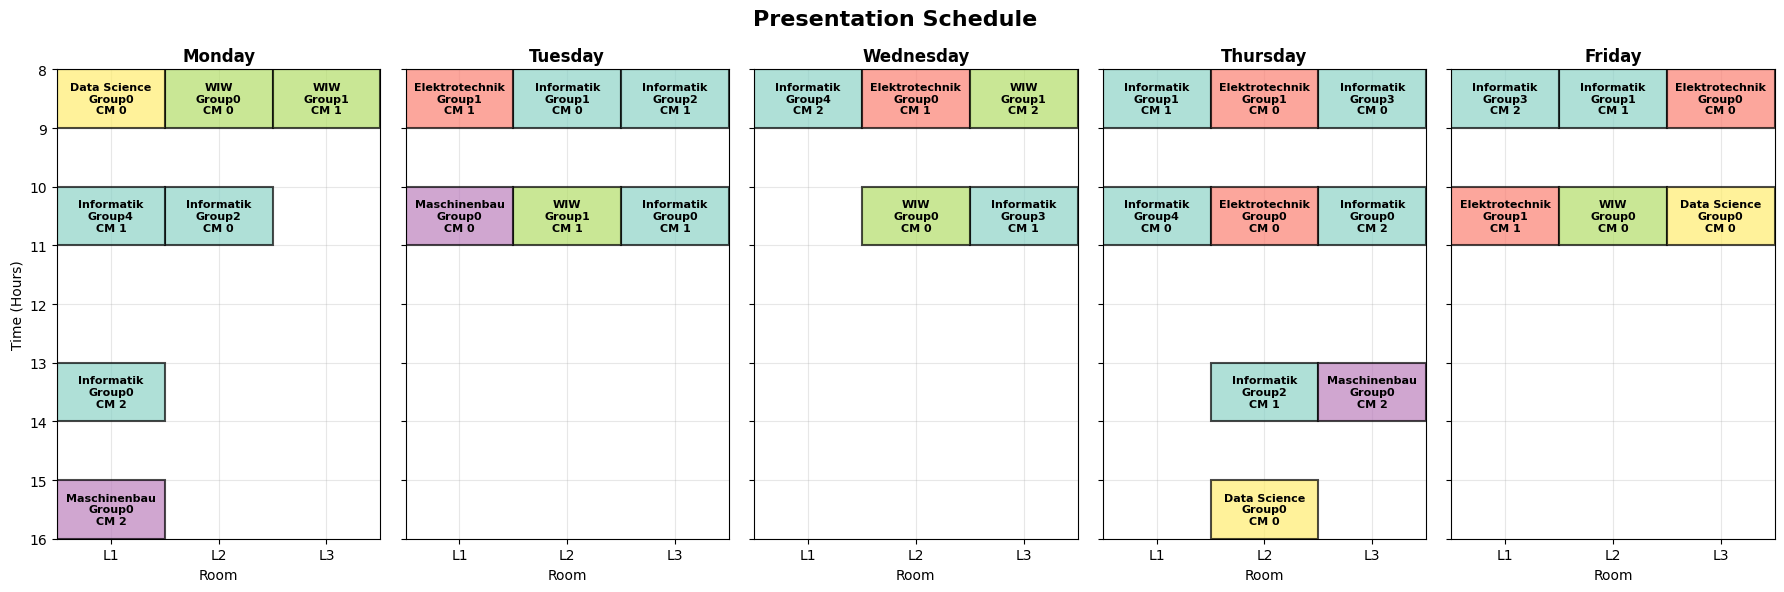

In [120]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

def display_timetable_ortools(solver, presentations, committee_assigned, all_courses, all_days, all_time_slots, all_rooms, num_groups, num_committees):
    """Display the OR-Tools solution as a matplotlib plot"""

    # Convert OR-Tools solution to the format your function expects
    solution_data = []

    for c in all_courses:
        for g in range(num_groups[c]):
            for d in all_days:
                for t in all_time_slots:
                    for r in all_rooms:
                        if solver.value(presentations[(c, g, d, t, r)]) == 1:
                            # Find which committee is assigned
                            committee_idx = None
                            for cm in range(num_committees[c]):
                                if solver.value(committee_assigned[(c, cm, d, t, r)]) == 1:
                                    committee_idx = cm
                                    break

                            solution_data.append({
                                'course': c,
                                'group': g,
                                'committee': committee_idx,
                                'day': d,
                                'time_slot': t,
                                'room': r
                            })

    # Create figure
    fig, axes = plt.subplots(1, len(all_days), figsize=(18, 6), sharey=True)
    fig.suptitle('Presentation Schedule', fontsize=16, fontweight='bold')

    # Color map for different courses
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_courses)))
    course_colors = {course: colors[i] for i, course in enumerate(all_courses)}

    for day_idx, day in enumerate(all_days):
        ax = axes[day_idx]
        ax.set_title(day, fontweight='bold')
        ax.set_xlim(0, len(all_rooms))
        ax.set_ylim(8, 16)
        ax.set_xticks(np.arange(len(all_rooms)) + 0.5)
        ax.set_xticklabels(all_rooms)
        ax.set_xlabel('Room')

        if day_idx == 0:
            ax.set_yticks(range(8, 17))
            ax.set_ylabel('Time (Hours)')

        ax.grid(True, alpha=0.3)
        ax.set_axisbelow(True)
        ax.invert_yaxis()

        # Plot presentations for this day
        for pres in solution_data:
            if pres['day'] == day:
                room_idx = all_rooms.index(pres['room'])

                # Parse time slot to get start and end hour
                start_hour, end_hour = map(int, pres['time_slot'].split('-'))

                course = pres['course']
                group = pres['group']
                committee_idx = pres['committee']

                color = course_colors[course]

                # Draw rectangle
                rect = Rectangle((room_idx, start_hour), 1, end_hour - start_hour,
                                 linewidth=1.5, edgecolor='black',
                                 facecolor=color, alpha=0.7)
                ax.add_patch(rect)

                # Add text in the center
                text = f"{course}\nGroup{group}\nCM {committee_idx}"
                ax.text(room_idx + 0.5, (start_hour + end_hour) / 2, text,
                        ha='center', va='center', fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.show()


if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print("Solution found!")
    display_timetable_ortools(
        solver,
        presentations,
        committee_assigned,
        all_courses,
        all_days,
        all_time_slots,
        all_rooms,
        num_groups,
        num_committees
    )
else:
    print("No solution found!")